In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

## Read and Visualization

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures"""

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Create a list with the filepaths
train_dir = Path('/kaggle/input/wildfire-prediction-dataset/train')
filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir=Path('/kaggle/input/wildfire-prediction-dataset/test')
filepaths_test = list(test_dir.glob(r'**/*.jpg'))

val_dir=Path('/kaggle/input/wildfire-prediction-dataset/valid')
filepaths_valid = list(val_dir.glob(r'**/*.jpg'))

df_train = proc_img(filepaths)
df_test = proc_img(filepaths_test)
df_valid=proc_img(filepaths_valid)

In [4]:
df_train.head()

Filepath       Label
0  /kaggle/input/wildfire-prediction-dataset/trai...    wildfire
1  /kaggle/input/wildfire-prediction-dataset/trai...    wildfire
2  /kaggle/input/wildfire-prediction-dataset/trai...  nowildfire
3  /kaggle/input/wildfire-prediction-dataset/trai...  nowildfire
4  /kaggle/input/wildfire-prediction-dataset/trai...  nowildfire

In [5]:
def print_df(df):

    print(f'Number of pictures: {df.shape[0]}\n')
    print(f'Number of different labels: {len(df.Label.unique())}\n')
    print(f'Labels: {df.Label.unique()}')  
def printhead(df):
    print(df.head(5))
    

In [6]:
print("length of image is: ", plt.imread(df_test["Filepath"][0]).shape[0], "width is: ", plt.imread(df_test["Filepath"][0]).shape[1]," and number of channels are: ", plt.imread(df_test["Filepath"][0]).shape[2])


length of image is:  350 width is:  350  and number of channels are:  3


In [7]:
printhead(df_train)

                                            Filepath       Label
0  /kaggle/input/wildfire-prediction-dataset/trai...    wildfire
1  /kaggle/input/wildfire-prediction-dataset/trai...    wildfire
2  /kaggle/input/wildfire-prediction-dataset/trai...  nowildfire
3  /kaggle/input/wildfire-prediction-dataset/trai...  nowildfire
4  /kaggle/input/wildfire-prediction-dataset/trai...  nowildfire


In [8]:
print_df(df_train)


Number of pictures: 30250

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']


In [9]:
print_df(df_test)

Number of pictures: 6300

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']


In [10]:
print_df(df_valid)

Number of pictures: 6300

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']


In [11]:
def viz_img(df):
    df_1 = df.copy().reset_index()     
    fig, axes = plt.subplots( nrows=2,ncols=3, figsize=(20, 10), subplot_kw={'xticks': [], 'yticks': []}) 
    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_1.Filepath[i])) 
        ax.set_title(df_1.Label[i])
    plt.tight_layout(pad=0.5)
    plt.show()    

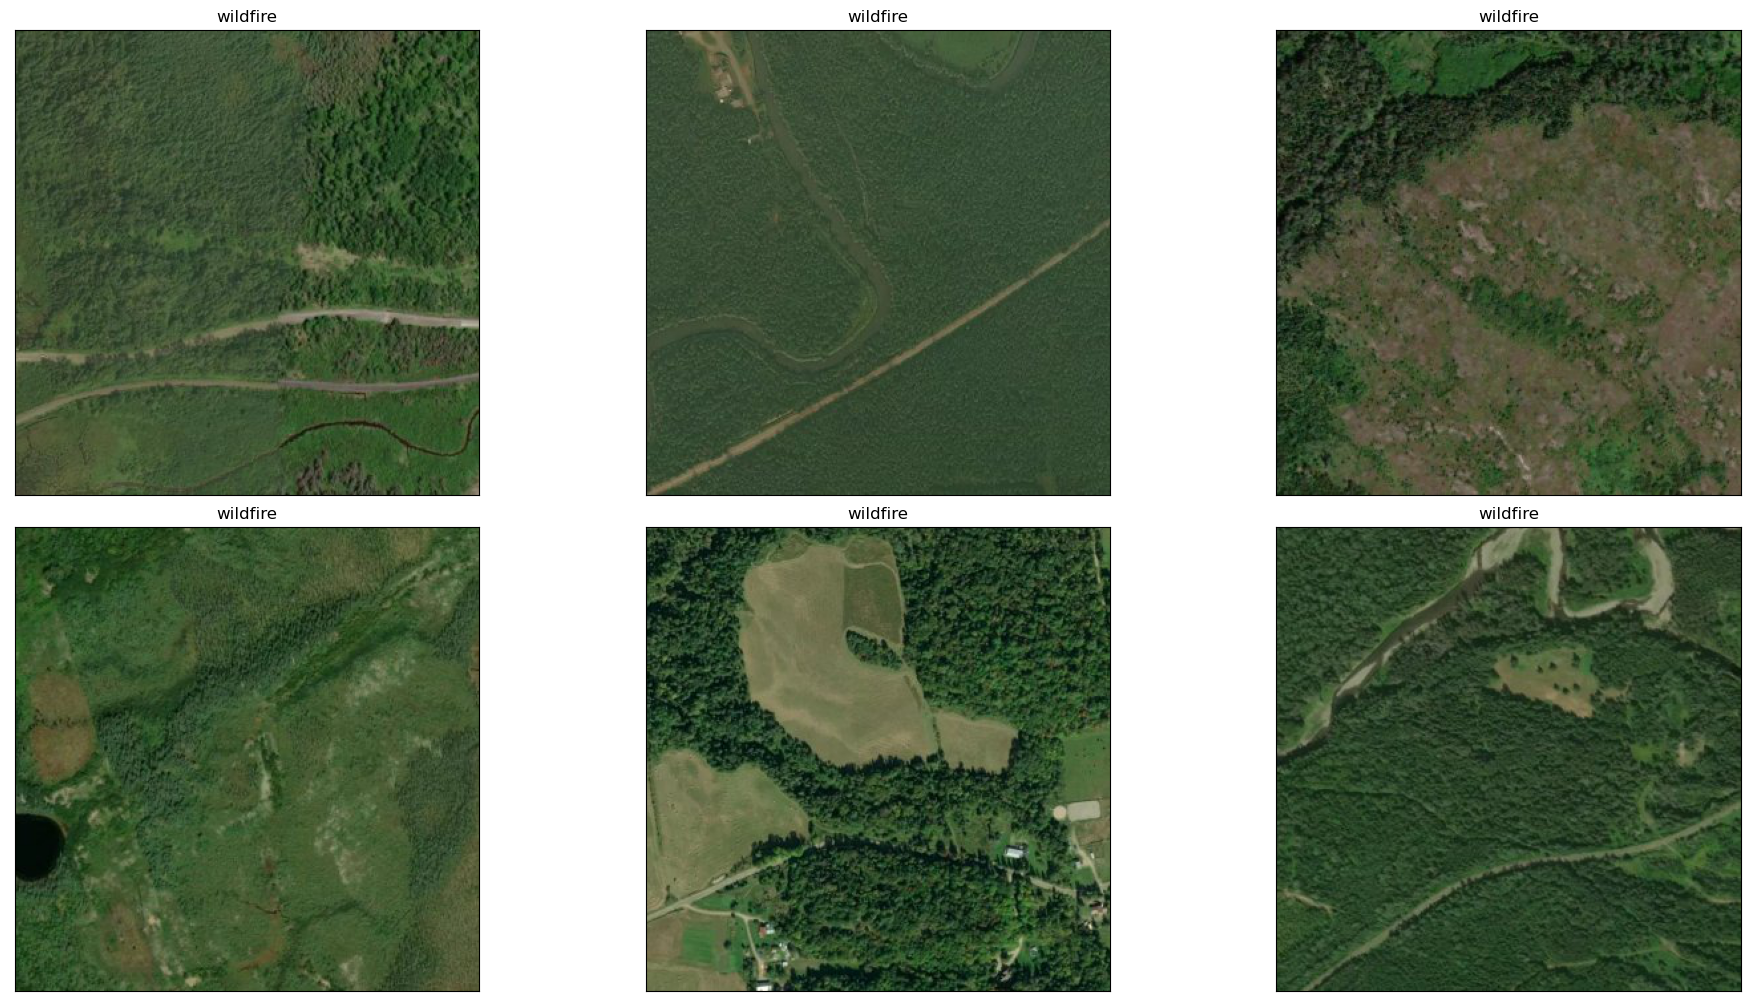

In [12]:
df1=df_train.copy()
df1=df1[df1.Label=='wildfire']
viz_img(df1)

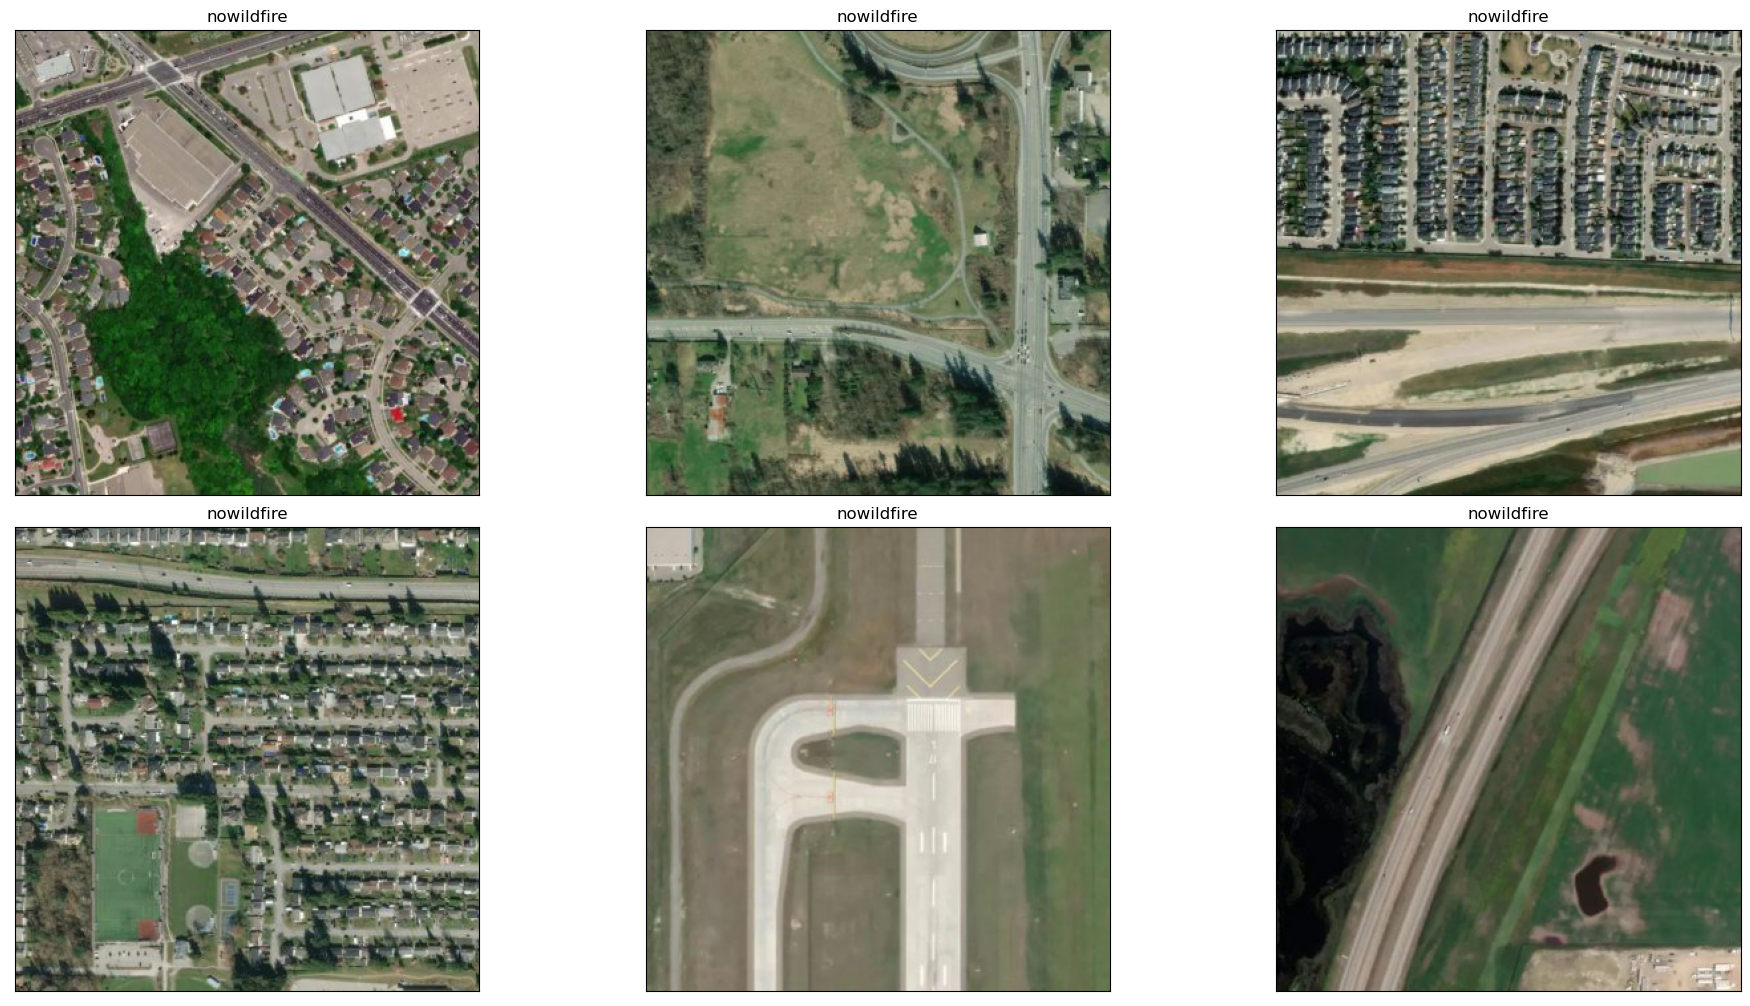

In [13]:
df1=df_train.copy()
df1=df1[df1.Label=='nowildfire']
viz_img(df1)

# Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

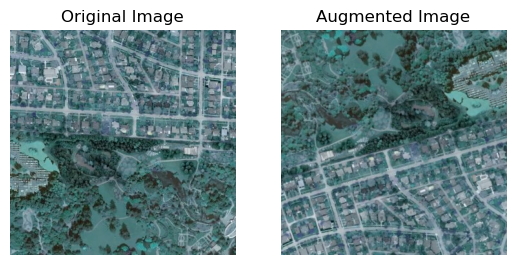

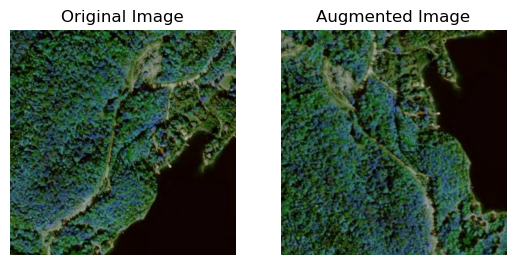

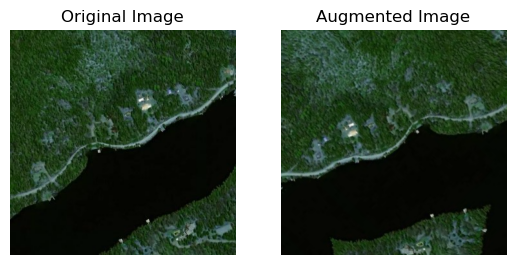

In [15]:
def augment_image(image):
    aug = A.Compose([
        A.Flip(),
        A.Rotate(limit=75,always_apply=True),
    ])
    augmented_image = aug(image=image)['image']
    return augmented_image
def show_original_augment_image(df):
    random_data = df.sample(n=3)
    for i in range(len(random_data)):
        image = cv.imread(random_data.iloc[i].Filepath)
        augmented_image = augment_image(image)

        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(1,2,2)
        plt.imshow(augmented_image)
        plt.title("Augmented Image")
        plt.axis('off')
        plt.show()

show_original_augment_image(df_train)

In [16]:
print("length of image is:", plt.imread(df_valid["Filepath"][0]).shape[0], "width is:", plt.imread(df_valid["Filepath"][0]).shape[1],"and number of channels are:", plt.imread(df_test["Filepath"][0]).shape[2])


length of image is: 350 width is: 350 and number of channels are: 3


In [17]:
BATCH_SIZE = 256
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255., preprocessing_function=augment_image)
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')
val_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
val_generator = val_datagen.flow_from_dataframe(df_valid,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=True,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')
test_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    shuffle=False,
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (350,350),
                                                    class_mode = 'categorical')

Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


In [18]:
df_train.shape

(30250, 2)

# Build Model

In [19]:
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [21]:
image_shape = (350, 350, 3)
weight_decay = 1e-3
first_model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(100,activation='relu'),
    Dropout(0.4),
    Dense(2,activation='softmax')
])
first_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 349, 349, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 86, 86, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 32)       0

# Train Model

In [ ]:

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint('first_model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)

optimizer = optimizers.Adam(learning_rate= 0.00001, weight_decay= 1e-5)
checkpointer = ModelCheckpoint('first_model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.00001, weight_decay= 1e-5)
first_model.compile(loss= 'categorical_crossentropy', optimizer= 'adam',
                    metrics=['AUC','acc'])
history = first_model.fit(train_generator,
                    epochs = 40,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [checkpointer, early_stopping])
#first_model.compile(loss= 'categorical_crossentropy', optimizer= 'adam',
#                    metrics=['AUC','acc'])
#history = first_model.fit(train_generator,
#                    epochs = 40,
#                    verbose = 1,
#                    validation_data = val_generator,
#                    callbacks = [checkpointer, early_stopping])

Epoch 1/40
119/119 [==============================] - ETA: 0s - loss: 0.3852 - auc: 0.9251 - acc: 0.8602
Epoch 1: val_loss improved from inf to 0.20270, saving model to first_model.hdf5
119/119 [==============================] - 546s 5s/step - loss: 0.3852 - auc: 0.9251 - acc: 0.8602 - val_loss: 0.2027 - val_auc: 0.9783 - val_acc: 0.9221
Epoch 2/40
119/119 [==============================] - ETA: 0s - loss: 0.2212 - auc: 0.9729 - acc: 0.9226
Epoch 2: val_loss improved from 0.20270 to 0.16319, saving model to first_model.hdf5
119/119 [==============================] - 302s 3s/step - loss: 0.2212 - auc: 0.9729 - acc: 0.9226 - val_loss: 0.1632 - val_auc: 0.9857 - val_acc: 0.9441
Epoch 3/40
119/119 [==============================] - ETA: 0s - loss: 0.1999 - auc: 0.9781 - acc: 0.9306
Epoch 3: val_loss improved from 0.16319 to 0.16060, saving model to first_model.hdf5
119/119 [==============================] - 299s 3s/step - loss: 0.1999 - auc: 0.9781 - acc: 0.9306 - val_loss: 0.1606 - val_au

# Plot Graphs

In [ ]:
import matplotlib.pyplot as pltt

plt.plot(history.history['acc'],color='red',label='train')
plt.plot(history.history['val_acc'],color='blue',label='validation')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Test Data

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

from keras import Sequential, Input, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Dropout

In [ ]:
pred = np.argmax(model.predict(test_generator), axis=1)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15),subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0, len(df_test) - 1, 20)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_generator.filepaths[random_index[i]]))
    if labels[test_generator.labels[random_index[i]]] == pred_label[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"Actual: {labels[test_generator.labels[random_index[i]]]}\nPredicted: {pred_label[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()
plt.show()

# Pre-Trained Model

In [ ]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=df_test,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images


In [ ]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}


    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
m = get_model(tf.keras.applications.ResNet50V2)

In [ ]:
history = m.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
pred = m.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = list(df_test.Label)
acc = accuracy_score(y_test,pred)
print(f'## Best Model: ResNet50V2 with {acc*100:.2f}% accuracy on the test set')


In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (7,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.Filepath.iloc[i]))
    ax.set_title(f"True: {df_test.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()